# Prepering Data

In [1]:
# import necessary libraries of pandas
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import statsmodels.api as sm               # Import for statsmodels
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# import excel data & choose the relevant columns & organise the categories
df = pd.read_excel(r"C:\Users\noy\OneDrive - mail.tau.ac.il\פרויקט מעבדה\project_data.xlsx", sheet_name="the data")

df = pd.DataFrame(df, columns=["Gender", "Occupation"])
df['Occupation'] = df['Occupation'].replace({
    'Health professions': 'Healthcare & Rescue Services',
    'Health Professions': 'Healthcare & Rescue Services',
    'rescue services': 'Healthcare & Rescue Services',
    'Science and Eng.': 'Science & Technology',
    'Information Technologies': 'Science & Technology',
    'HighTech': 'Science & Technology',
    'HIghTech': 'Science & Technology',
    'Machine professional': 'Science & Technology',
    'Business and finances': 'Business & Management',
    'Junior management': 'Business & Management',
    'Junior Management' : 'Business & Management',
    'Senior Management': 'Business & Management',
    'Service and sales': 'Service & Sales',
    'Agriculture': 'Arts, Sports & Communication',
    'Sports': 'Arts, Sports & Communication',
    'Performing arts': 'Arts, Sports & Communication',
    'Design, craft & cooking':  'Arts, Sports & Communication',
    'journalism and translation': 'Arts, Sports & Communication',
    'Retired': 'Retired and Unemployed',
    'Unemployed': 'Retired and Unemployed',
    'government': 'Government',
})
# display(df)

# Calculate count, total and mean
count_df = df.groupby(['Gender', 'Occupation']).size().reset_index(name='Count')
total_counts = count_df.groupby('Gender')['Count'].sum().reset_index(name='Total')
count_df = pd.merge(count_df, total_counts, on='Gender')
count_df['Percentage'] = (count_df['Count'] / count_df['Total']) * 100

# Prepare data for plotting
female_data = count_df[count_df['Gender'] == 'נקבה'].groupby(['Occupation'])['Percentage'].mean().reset_index()
male_data = count_df[count_df['Gender'] == 'זכר'].groupby(['Occupation'])['Percentage'].mean().reset_index()

# Combine female and male data
combined_data = pd.merge(female_data, male_data, on='Occupation', how='outer', suffixes=('_Female', '_Male')).fillna(0)

# Sort by male percentages in ascending order
combined_data = combined_data.sort_values(by='Percentage_Male', ascending=True)

### Gender Distribution by Occupation

# Generating Correlations Plots

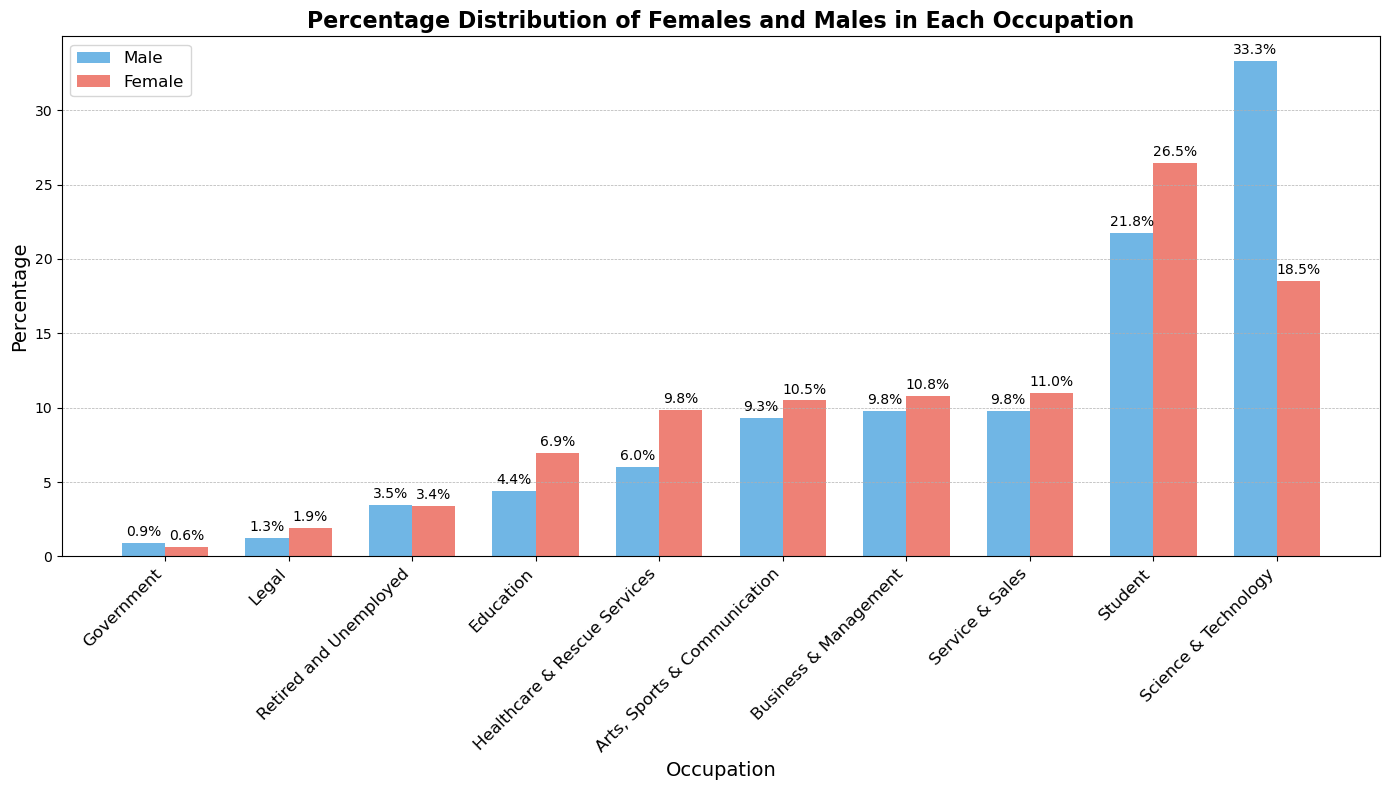

In [2]:
display(Markdown("### Gender Distribution by Occupation"))

# Plotting grouped bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(combined_data))

# Define color palette
colors_male = '#3498db'
colors_female = '#e74c3c'

# Plot male and female data with transparency to add depth
bars_male = ax.bar(index, combined_data['Percentage_Male'], bar_width, label='Male', color=colors_male, alpha=0.7)
bars_female = ax.bar(index + bar_width, combined_data['Percentage_Female'], bar_width, label='Female', color=colors_female, alpha=0.7)

# Add gridlines for better readability
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Set labels and titles with larger fonts
ax.set_xlabel('Occupation', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Percentage Distribution of Females and Males in Each Occupation', fontsize=16, fontweight='bold')

# Adjust the ticks and their labels for better readability
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_data['Occupation'], rotation=45, ha='right', fontsize=12)

# Move the legend to the upper right corner with larger font size
ax.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)

# Add percentage labels to bars
for bar in bars_male:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10, color='black')

for bar in bars_female:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.savefig('plot_name.png', format='png', dpi=300)  # Saves the plot as a PNG file with high resolution

plt.show()

# Performing ANOVA Test

In [3]:
# ANOVA test & show in a table & Color Significance cells
model = ols('Count ~ C(Occupation) + C(Gender)', data=count_df).fit()
anova_table_raw = sm.stats.anova_lm(model, type=2)

def highlight_significant(p_value, threshold=0.05):
    color = 'background-color: #80aaff' if p_value < threshold else ''
    return color
anova_table_styled = anova_table_raw.style.applymap(highlight_significant, subset=['PR(>F)'])

display(Markdown("### ANOVA Results: Analyzing the Effect of Gender and Occupation"))
display(anova_table_styled)
print('Significant cells are highlighted in color.\n')

profession_p_value = anova_table_raw.at['C(Occupation)', 'PR(>F)']
gender_p_value = anova_table_raw.at['C(Gender)', 'PR(>F)']

### ANOVA Results: Analyzing the Effect of Gender and Occupation

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),9.000000,78421.800000,8713.533333,6.073654,0.006485
C(Gender),1.000000,3075.200000,3075.200000,2.143528,0.177207
Residual,9.000000,12911.800000,1434.644444,nan,nan


Significant cells are highlighted in color.



# Performing Tukey's Test

In [4]:
# Perform Post Hoc tests
if profession_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Occupation"))
    tukey_results_prof = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Occupation'], alpha=0.05)
    tukey_results_prof_df = pd.DataFrame(tukey_results_prof.summary().data[1:], columns=tukey_results_prof.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == True]
    reject_false_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == False]

    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

if gender_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Gender"))
    tukey_results_gender = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Gender'], alpha=0.05)
    tukey_results_gender_df = pd.DataFrame(tukey_results_gender.summary().data[1:], columns=tukey_results_gender.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_gender_df[tukey_results_gender_df['reject'] == True]
    reject_false_df = tukey_results_gender_df[tukey_results_gender_df['reject'] == False]
    
    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

### Post-Hoc Test (Tukey's HSD) for Occupation

**Reject = True:**

,group1,group2,meandiff,p-adj,lower,upper,reject
21,Education,Science & Technology,161.500000,0.044500,3.218100,319.781900,True
27,Government,Science & Technology,196.000000,0.013100,37.718100,354.281900,True
29,Government,Student,170.500000,0.032300,12.218100,328.781900,True
36,Legal,Science & Technology,190.500000,0.015900,32.218100,348.781900,True
38,Legal,Student,165.000000,0.039300,6.718100,323.281900,True
39,Retired and Unemployed,Science & Technology,176.500000,0.026100,18.218100,334.781900,True


**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,"Arts, Sports & Communication",Business & Management,3.000000,1.000000,-155.281900,161.281900,False
1,"Arts, Sports & Communication",Education,-32.500000,0.996400,-190.781900,125.781900,False
2,"Arts, Sports & Communication",Government,-67.000000,0.787300,-225.281900,91.281900,False
3,"Arts, Sports & Communication",Healthcare & Rescue Services,-16.500000,1.000000,-174.781900,141.781900,False
4,"Arts, Sports & Communication",Legal,-61.500000,0.849800,-219.781900,96.781900,False
5,"Arts, Sports & Communication",Retired and Unemployed,-47.500000,0.958600,-205.781900,110.781900,False
6,"Arts, Sports & Communication",Science & Technology,129.000000,0.141700,-29.281900,287.281900,False
7,"Arts, Sports & Communication",Service & Sales,3.500000,1.000000,-154.781900,161.781900,False
8,"Arts, Sports & Communication",Student,103.500000,0.328600,-54.781900,261.781900,False
9,Business & Management,Education,-35.500000,0.993300,-193.781900,122.781900,False
